In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here we can see that there are missing values in some features, such as 'Age' and 'Cabin'. \
Things we need to do :
- Convert categorical features into numeric.
- Features have a widely different scale, so we have to convert them into the same scale.
- Process missing values.

What data is missing ?

In [5]:
print(df_train.size)
df_train.isnull().sum()

10692


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = df_train.isnull().sum() / df_train.isnull().count() * 100
percent = (round(percent, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', "%"])
missing_data

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
SibSp,0,0.0
Parch,0,0.0


__Data Preprocessing__

Drop 'PassengerId' from training set, but not from test set since it is needed for submission

In [4]:
df_train = df_train.drop(['PassengerId'], axis=1)

'Cabin' \
The letter in cabin number, for instance C in C123, refers to the deck. So we create a new feature containing a person's deck 

In [5]:
import re

deck = {"A" : 1, "B" : 2, "C" : 3, "D" : 4, "E" : 5, "F" : 6, "G" : 7, "U" : 8}
# Process training and test set together
data = [df_train, df_test]

for dataset in data:
    dataset["Cabin"] = dataset["Cabin"].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0) # Fill missing values with 0
    dataset['Deck'] = dataset['Deck'].astype(int) # Convert feature type to int

# Drop 'Cabin' feature
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

'Age' \
Fill missing values with random number in the range of [mean-std, mean+std]

In [6]:
data = [df_train, df_test]

for dataset in data:
    mean = df_train['Age'].mean()
    std = df_test['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    # Generate random number 
    rand_num = np.random.randint(mean-std, mean+std, size=is_null)
    # Fill in missing values
    age = dataset.Age.copy()
    age[np.isnan(age)] = rand_num
    dataset['Age'] = age
    dataset['Age'] = df_train.Age.astype(int)

df_train.Age.isnull().sum()

0

'Embarked' \
Since there are only 2 missing values, we can just fill them with the most frequent one.

In [7]:
df_train.Embarked.describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [7]:
df_train.Embarked.mode()

0    S
dtype: object

In [8]:
data = [df_train, df_test]
for dataset in data:
    #dataset.Embarked = dataset.Embarked.fillna("S")

__Convert Features__

In [9]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,8
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,8
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,8


'Name' \
Extract title from name, convert into new feature 'Title'

In [10]:
data = [df_train, df_test]
titles = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}

for dataset in data:
    # Extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # Replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # Convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # Fill NaN with 0
    dataset['Title'] = dataset['Title'].fillna(0)
df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)

'Fare' \
Convert from 'float' to 'int64'

In [11]:
data = [df_train, df_test]
for dataset in data:
    dataset.Fare = dataset.Fare.fillna(0)
    dataset.Fare = dataset.Fare.astype(int)

'Sex' \
Convert into numeric

In [12]:
from sklearn.preprocessing import OrdinalEncoder
data = [df_train, df_test]
print(df_train.Sex.head())
genders = {"male" : 0, "female" : 1}
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object


'Ticket'

In [13]:
df_train.Ticket.describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

The 'Ticket' feature has too many unique values, so it will be hard to convert them into useful features. We drop them from the dataset

In [14]:
df_train = df_train.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

'Embarked' \
Convert feature into numeric

In [15]:
embark = {"S" : 0, "C" : 1, "Q" : 2}
data = [df_train, df_test]

for dataset in data:
    dataset.Embarked = dataset.Embarked.map(embark)

'SibSp' and 'Parch' \
These two features will be better if we combine them to show the total number of relatives a person has onboard the Titanic.

In [16]:
data = [df_train, df_test]
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Relatives'] > 0, 'Not_Alone'] = 0
    dataset.loc[dataset['Relatives'] == 0, 'Not_Alone'] = 1
    dataset['Not_Alone'] = dataset['Not_Alone'].astype(int)
df_train = df_train.drop(['SibSp', 'Parch'], axis=1)
df_test = df_test.drop(['SibSp', 'Parch'], axis=1)
df_train['Not_Alone'].value_counts()

1    537
0    354
Name: Not_Alone, dtype: int64

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Survived   891 non-null    int64
 1   Pclass     891 non-null    int64
 2   Sex        891 non-null    int64
 3   Age        891 non-null    int32
 4   Fare       891 non-null    int32
 5   Embarked   891 non-null    int64
 6   Deck       891 non-null    int32
 7   Title      891 non-null    int64
 8   Relatives  891 non-null    int64
 9   Not_Alone  891 non-null    int32
dtypes: int32(4), int64(6)
memory usage: 55.8 KB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Sex          418 non-null    int64
 3   Age          418 non-null    int32
 4   Fare         418 non-null    int32
 5   Embarked     418 non-null    int64
 6   Deck         418 non-null    int32
 7   Title        418 non-null    int64
 8   Relatives    418 non-null    int64
 9   Not_Alone    418 non-null    int32
dtypes: int32(4), int64(6)
memory usage: 26.2 KB


In [19]:
X = df_train.copy()
y = X.pop('Survived')

__Mutual Information__

In [20]:
discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
print(discrete_features)

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

[True, True, True, True, True, True, True, True, True]


Title        0.168384
Sex          0.150870
Fare         0.141621
Age          0.068249
Pclass       0.058107
Deck         0.055122
Relatives    0.047781
Not_Alone    0.020593
Embarked     0.014233
Name: MI Scores, dtype: float64

__Correlation Plot__

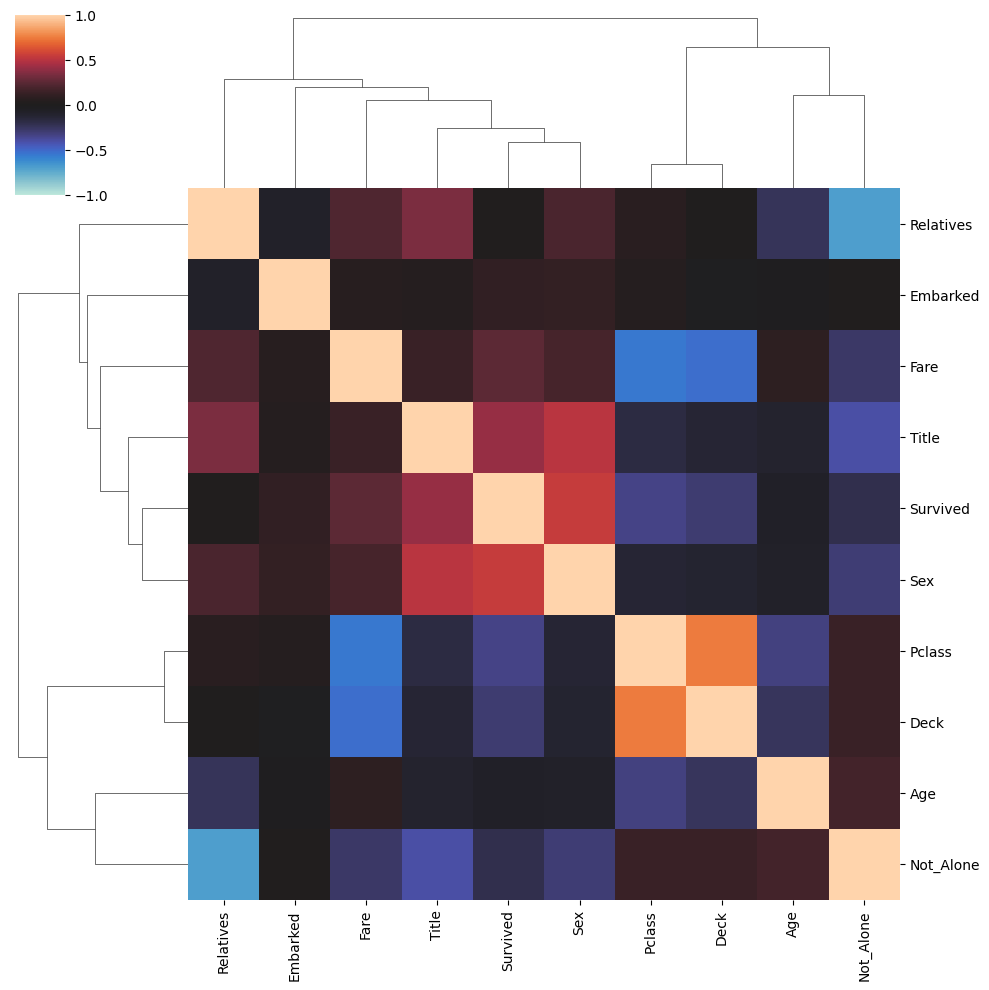

In [21]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

corrplot(df_train, annot=None)

From the plot, we can see the following features are tightly correlated :
- 'Pclass' and 'Deck'
- 'Relatives' and 'Not_Alone'
- 'Fare' and 'Pclass'
- 'Fare' and 'Deck'
- 'Survived' and 'Sex'
- 'Survived' and 'Pclass'

__Create New Features__

1. 'Age' times 'Pclass'
2. 'Fare' per person

In [22]:
data = [df_train, df_test]
for dataset in data:
    dataset['Age_Class'] = dataset.Age * dataset.Pclass
    dataset['Fare_Per_Person'] = dataset.Fare / (dataset.Relatives + 1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int) 

In [23]:
features = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Deck", "Title", "Relatives", "Not_Alone",
            "Age_Class", "Fare_Per_Person"]
print(df_train[features].corrwith(df_train.Survived))

Pclass            -0.338481
Sex                0.543351
Age               -0.070812
Fare               0.257482
Embarked           0.106811
Deck              -0.289569
Title              0.407753
Relatives          0.016639
Not_Alone         -0.203367
Age_Class         -0.321269
Fare_Per_Person    0.221239
dtype: float64


In [24]:
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Relatives,Not_Alone,Age_Class,Fare_Per_Person
0,0,3,0,22,7,0,8,1,1,0,66,3
1,1,1,1,38,71,1,3,3,1,0,38,35
2,1,3,1,26,7,0,8,2,0,1,78,7
3,1,1,1,35,53,0,3,3,1,0,35,26
4,0,3,0,35,8,0,8,1,0,1,105,8


In [25]:
df_test.head(8)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Relatives,Not_Alone,Age_Class,Fare_Per_Person
0,892,3,0,22,7,2,8,1,0,1,66,7
1,893,3,1,38,7,0,8,3,1,0,114,3
2,894,2,0,26,9,2,8,1,0,1,52,9
3,895,3,0,35,8,0,8,1,0,1,105,8
4,896,3,1,35,12,0,8,3,2,0,105,4
5,897,3,0,41,9,0,8,1,0,1,123,9
6,898,3,1,54,7,2,8,2,0,1,162,7
7,899,2,0,2,29,0,8,1,2,0,4,9


In [26]:
X = df_train.copy()
y = X.pop('Survived')

discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
print(discrete_features)

mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

[True, True, True, True, True, True, True, True, True, True, True]


Title              0.168384
Age_Class          0.155620
Sex                0.150870
Fare               0.141621
Fare_Per_Person    0.108601
Age                0.068249
Pclass             0.058107
Deck               0.055122
Relatives          0.047781
Not_Alone          0.020593
Embarked           0.014233
Name: MI Scores, dtype: float64

In [27]:
X_train = df_train.drop(["Not_Alone", "Embarked"], axis=1).copy()
y_train = X_train.pop("Survived")
X_test = df_test.drop(["PassengerId", "Not_Alone", "Embarked"], axis=1).copy()

model = XGBClassifier(learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)
pred = model.predict(X_test)

model.score(X_train, y_train)
accuracy = round(model.score(X_train, y_train) * 100, 2)
accuracy


88.78

__K-Fold Validation__

In [28]:
score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", score)
print("Mean:", score.mean())
print("Standard Deviation:", score.std())

Scores: [0.82681564 0.79775281 0.84831461 0.8258427  0.85393258]
Mean: 0.8305316678174629
Standard Deviation: 0.019870000951026166


Our model has a average accuracy of 82% with a standard deviation of 2.1%, where the standard deviation shows us how precise the estimates are.

__Hyperparameter Tuning__

In [29]:
xgb_params = dict(
    max_depth=7,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=200,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = round(xgb.score(X_train, y_train) * 100, 2)
xgb_acc

89.56

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(xgb, X_train, y_train, cv=5)
confusion_matrix(y_train, predictions)

array([[495,  54],
       [ 91, 251]], dtype=int64)

In [31]:
from sklearn.metrics import precision_score, recall_score
print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 0.8229508196721311
Recall: 0.7339181286549707


In [32]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions)

0.7758887171561051

In [33]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': xgb_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
